In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import TpotAutoml
from sklearn.model_selection import TimeSeriesSplit

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
pd.options.mode.chained_assignment = None

In [15]:
# user inputs:
SEED = 13
np.random.seed(SEED)
KEEP_ROWS_FRAC = 1.0 #0.05 # set to 1 if all rows are meant to be kept
skiprows_func = lambda i: i>0 and np.random.rand() > KEEP_ROWS_FRAC

In [16]:
usecols=['item_id', 'activation_date', 'city', 'region',
                              'parent_category_name', 'category_name', 
                             'item_seq_number', 'user_type', 'price_norm']

In [17]:
all_samples = pd.read_csv('data/all_samples_no_nulls.csv', usecols=usecols, skiprows=skiprows_func)

In [18]:
train = pd.read_csv('data/train.csv', usecols=['item_id', 'activation_date', 'deal_probability'])

In [19]:
all_samples.head()

,item_id,region,city,parent_category_name,category_name,item_seq_number,activation_date,user_type,price_norm
0,b912c3c6a6ad,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,2.0,2017-03-28,Private,-0.368621
1,2dac0150717d,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,19.0,2017-03-26,Private,0.170278
2,ba83aefab5dc,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,9.0,2017-03-20,Private,0.350379
3,02996f1dd2ea,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,286.0,2017-03-25,Company,0.288374
4,7c90be56d2ab,Волгоградская область,Волгоград,Транспорт,Автомобили,3.0,2017-03-16,Private,-0.803530


In [20]:
train = train.merge(all_samples, how='left', on=['item_id', 'activation_date'])

In [21]:
train = train.dropna()

In [22]:
train = train.sort_values(by='activation_date').drop('activation_date', axis=1).set_index('item_id')

In [23]:
train = pd.get_dummies(train)

In [24]:
list(train)

['deal_probability',
 'item_seq_number',
 'price_norm',
 'region_Алтайский край',
 'region_Башкортостан',
 'region_Белгородская область',
 'region_Владимирская область',
 'region_Волгоградская область',
 'region_Воронежская область',
 'region_Иркутская область',
 'region_Калининградская область',
 'region_Кемеровская область',
 'region_Краснодарский край',
 'region_Красноярский край',
 'region_Нижегородская область',
 'region_Новосибирская область',
 'region_Омская область',
 'region_Оренбургская область',
 'region_Пермский край',
 'region_Ростовская область',
 'region_Самарская область',
 'region_Саратовская область',
 'region_Свердловская область',
 'region_Ставропольский край',
 'region_Татарстан',
 'region_Тульская область',
 'region_Тюменская область',
 'region_Удмуртия',
 'region_Ханты-Мансийский АО',
 'region_Челябинская область',
 'region_Ярославская область',
 'city_Абан',
 'city_Абатское',
 'city_Абдулино',
 'city_Абинск',
 'city_Абрамовка',
 'city_Абрау-Дюрсо',
 'city_Авдон'

In [25]:
len(train)

1503424

In [ ]:
target = 'deal_probability'
TIMEOUT_MINS = None
SCORING = 'r2'
X = (train.drop(target, axis=1)).values
y = train[target].values
tss = TimeSeriesSplit(n_splits=4)
train_index, test_index = list(tss.split(X))[-1]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

config_dict = {'sklearn.ensemble.GradientBoostingRegressor': {
        'n_estimators': [100, 200, 400],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },
        'sklearn.ensemble.RandomForestRegressor': {
        'n_estimators': [100, 200, 400],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },
              }

tpot = TpotAutoml(mode='regression',
                  max_time_mins=TIMEOUT_MINS,
                  generations = 1, population_size=1,
                  scoring=SCORING,
                  random_state=SEED,
                  n_jobs=1,
                  verbosity=2,
                  cv=TimeSeriesSplit(n_splits=3),
                  config_dict=config_dict,                 
                 )

In [ ]:
# base_model = GradientBoostingRegressor()
base_model = RandomForestRegressor()
# tpot = RandomizedSearchCV(estimator=base_model, random_state=RS,
# #                           param_distributions=config_dict['sklearn.ensemble.GradientBoostingRegressor'],
#                           param_distributions=config_dict['sklearn.ensemble.RandomForestRegressor'],
#                          n_iter=15,
#                          scoring='r2',
#                          cv=TimeSeriesSplit(n_splits=4),
#                          verbose=2,
#                          n_jobs=4)

tpot = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=0.2, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
           oob_score=False, random_state=None, verbose=2, warm_start=False)

In [ ]:
tpot.fit(X_train, y_train)

In [14]:
# feat_importance_entropy = list(zip(train.drop(target, axis=1).columns.values, tpot.best_estimator_.feature_importances_))
feat_importance_entropy = list(zip(train.drop(target, axis=1).columns.values, tpot.feature_importances_))

In [15]:
sorted(list(feat_importance_entropy), key=lambda x:x[1], reverse=True)[:10]

[('price_norm', 0.14535100147997626),
 ('parent_category_name_Личные вещи', 0.11479804742887222),
 ('item_seq_number', 0.10215752274522943),
 ('parent_category_name_Услуги', 0.08895697767185576),
 ('category_name_Предложение услуг', 0.08280025844802377),
 ('category_name_Одежда, обувь, аксессуары', 0.06665230839277253),
 ('category_name_Детская одежда и обувь', 0.04200329482420484),
 ('category_name_Товары для детей и игрушки', 0.037962425590185776),
 ('category_name_Автомобили', 0.021755137970076346),
 ('user_type_Private', 0.021206179343578723)]

In [16]:
test_score = tpot.score(X_test, y_test)
print(test_score)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    7.0s finished


0.17719105921764455


In [17]:
rmse = np.sqrt(np.mean((tpot.predict(X_test) - y_test) ** 2))
rmse

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.8s finished


0.23522198925263973

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    6.9s finished


0.14071674503963355
0.13809502820236524


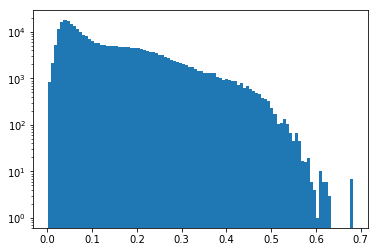

In [18]:
plt.hist(tpot.predict(X_test), log=True, bins=100)
print(tpot.predict(X_test).mean())
print(y_test.mean())

In [19]:
from analysis import Analysis
ea = Analysis(tpot, X_train, y_train, X_test, y_test,
                           mode='regression', target=target,
                           features=train.drop(target, axis=1).columns,
                           test_samples_index=test_index, random_state=SEED)

In [20]:
# ea.get_feature_importance(sort=True);

In [21]:
list(ea.feature_importance.items())[:10]

AttributeError: 'Analysis' object has no attribute 'feature_importance'

In [ ]:
# tpot.best_estimator_

In [24]:
test = pd.read_csv('data/test.csv', usecols=['item_id', 'activation_date'])
len(test)

508438

In [25]:
test = test.merge(all_samples, how='left', on=['item_id', 'activation_date'])
len(test)

508438

In [32]:
test = test.sort_values(by='activation_date').drop('activation_date', axis=1).set_index('item_id')

In [27]:
test = pd.get_dummies(test)

In [62]:
test_consistent = pd.DataFrame()
for feat in train.columns.values:
    if feat not in test:
        test_consistent.loc[:, feat] = [0.0]*len(test)
    else:
        test_consistent.loc[:, feat] = test[feat].values

In [77]:
test_consistent = test_consistent.set_index(test.index)

In [63]:
assert len(test_consistent.columns) == len(train.columns)

In [64]:
test_consistent = test_consistent.drop('deal_probability', axis=1)

In [65]:
test_consistent.head()

,item_seq_number,price_norm,region_Алтайский край,region_Башкортостан,region_Белгородская область,region_Владимирская область,region_Волгоградская область,region_Воронежская область,region_Иркутская область,region_Калининградская область,...,category_name_Спорт и отдых,category_name_Телефоны,category_name_Товары для детей и игрушки,category_name_Товары для животных,category_name_Товары для компьютера,category_name_Фототехника,category_name_Часы и украшения,user_type_Company,user_type_Private,user_type_Shop
0,59.0,0.432553,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,-0.024607,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,37.0,-0.069813,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,70.0,-0.609818,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10.0,0.585951,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [66]:
test_consistent['deal_probability'] = tpot.predict(test_consistent.values)

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    9.7s finished


In [67]:
import pickle
model_name = 'rf_tabular'
pickle.dump(tpot, open('saved_models/{}.pickle'.format(model_name), 'wb'))
model = pickle.load(open('saved_models/{}.pickle'.format(model_name), 'rb'))

In [78]:
test_consistent['deal_probability'][:2]

item_id
c4f49ffd12d7    0.204614
1ab4beda220b    0.040523
Name: deal_probability, dtype: float64

In [81]:
test_consistent['deal_probability'].reset_index().set_index('item_id').to_csv('predictions/tabular.csv')